In [1]:
import time
import os

# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""
import pandas as pd
import tensorflow as tf
import numpy as np
import scipy.sparse as sp
import scipy
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import sys
sys.path.append('../gae/')
from gae.optimizer import OptimizerAE, OptimizerVAE
from gae.input_data import load_data, parse_index_file
from gae.model import GCNModelAE, GCNModelVAE
from gae.preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges

/Users/attia/Desktop/Work/workenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Settings
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 32, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 16, 'Number of units in hidden layer 2.')
flags.DEFINE_float('weight_decay', 0., 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')

flags.DEFINE_string('model', 'gcn_ae', 'Model string.')
flags.DEFINE_string('dataset', 'cora', 'Dataset string.')
flags.DEFINE_integer('features', 1, 'Whether to use features (1) or not (0).')

model_str = FLAGS.model
dataset_str = FLAGS.dataset

## Load and preprocessing data

In [3]:
# X : (n,m) history matrix
# A : (n,n) questions adjacency matrix
X = pd.read_hdf('history_small.hdf', key='hist') #_small
A = pd.read_pickle('adjacency_small.pkl') #_small
A = A[sorted(A.columns)]

# Re-encoding A, X
X[X==1] = 2  #valid
X[X==0] = 1 #not valid
X[X==-100] = 0 #missing
X = X.astype(float)

# Thresholding A to have a non fully-connected graphs
A[A<=0.7] = 0

# Convert to sparse matrices
adj = scipy.sparse.csr_matrix(A.values)
features = scipy.sparse.csr_matrix(X)

print('Adjacency Matrix %s, Bi-Partite (=Features) Matrix %s' % (adj.shape, features.shape))

# Adjacency diagonal must be null
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
adj.eliminate_zeros()
#assert np.diag(adj.todense()).sum() == 0

Adjacency Matrix (878, 878), Bi-Partite (=Features) Matrix (878, 290)


In [4]:
scipy.sparse.csr_matrix(A.values)

<878x878 sparse matrix of type '<class 'numpy.float64'>'
	with 516510 stored elements in Compressed Sparse Row format>

## Plot BiPartite Graph

In [59]:
users_idx = np.random.choice(X.columns, 20)
ex_idx = np.random.choice(X.index, 40)
temp = X.loc[ex_idx][users_idx]

In [60]:
def nx_graph_from_biadjacency_matrix(M):
    # Give names to the nodes in the two node sets
    U = [ "Q{}".format(i) for i in range(M.shape[0]) ]
    V = [ "U{}".format(i) for i in range(M.shape[1]) ]

    # Create the graph and add each set of nodes
    G = nx.Graph()
    G.add_nodes_from(U, bipartite=0)
    G.add_nodes_from(V, bipartite=1)

    # Find the non-zero indices in the biadjacency matrix to connect 
    # those nodes
    G.add_edges_from([ (U[i], V[j]) for i, j in zip(*M.nonzero()) ])

    return G

In [61]:
M = scipy.sparse.csc_matrix(temp)

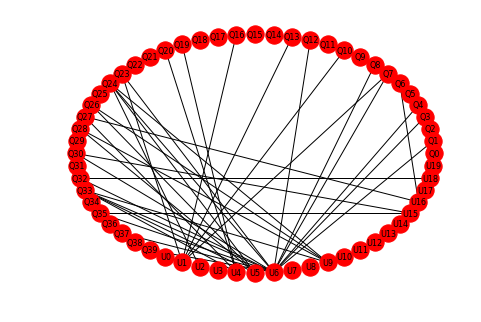

In [63]:
import networkx as nx, numpy as np
from networkx.algorithms import bipartite
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
%matplotlib inline

#RB = nx.complete_bipartite_graph(3, 2)
#A  = csc_matrix(bipartite.biadjacency_matrix(RB, row_order=bipartite.sets(RB)[0]))
G = nx_graph_from_biadjacency_matrix(M)
nx.draw_circular(G, node_color = "red", with_labels = True, font_size=8)

## Train/Val/Test set split

In [4]:
def ismember(a, b, tol=5):
    rows_close = np.all(np.round(a - b[:, None], tol) == 0, axis=-1)
    return (np.all(np.any(rows_close, axis=-1), axis=-1) and
            np.all(np.any(rows_close, axis=0), axis=0))

In [5]:
# 5% of data for val and test set
adj_triu = sp.triu(adj)
adj_tuple = sparse_to_tuple(adj_triu)
edges = adj_tuple[0]
edges_all = sparse_to_tuple(adj)[0]
num_test = int(np.floor(edges.shape[0] / 20.))
num_val = int(np.floor(edges.shape[0] / 20.))

# Get edges for sets
all_edge_idx = list(range(edges.shape[0]))
np.random.shuffle(all_edge_idx)
val_edge_idx = all_edge_idx[:num_val]
test_edge_idx = all_edge_idx[num_val:(num_val + num_test)]
test_edges = edges[test_edge_idx]
val_edges = edges[val_edge_idx]
train_edges = np.delete(edges, np.hstack([test_edge_idx, val_edge_idx]), axis=0)

In [6]:
test_edges_false = []
while len(test_edges_false) < len(test_edges):
    idx_i = np.random.randint(0, adj.shape[0])
    idx_j = np.random.randint(0, adj.shape[0])
    if idx_i == idx_j:
        continue
    if ismember([idx_i, idx_j], edges_all):
        continue
    if test_edges_false:
        if ismember([idx_j, idx_i], np.array(test_edges_false)):
            continue
        if ismember([idx_i, idx_j], np.array(test_edges_false)):
            continue
    test_edges_false.append([idx_i, idx_j])
    print('\r Test Edges False %d / Test Edges %d' % (len(test_edges_false), len(test_edges)), end='')

 Test Edges False 12890 / Test Edges 12890

In [7]:
val_edges_false = []
while len(val_edges_false) < len(val_edges):
    idx_i = np.random.randint(0, adj.shape[0])
    idx_j = np.random.randint(0, adj.shape[0])
    if idx_i == idx_j:
        continue
    if ismember([idx_i, idx_j], train_edges):
        continue
    if ismember([idx_j, idx_i], train_edges):
        continue
    if ismember([idx_i, idx_j], val_edges):
        continue
    if ismember([idx_j, idx_i], val_edges):
        continue
    if val_edges_false:
        if ismember([idx_j, idx_i], np.array(val_edges_false)):
            continue
        if ismember([idx_i, idx_j], np.array(val_edges_false)):
            continue
    val_edges_false.append([idx_i, idx_j])
    print('\r Val Edges False %d / Val Edges %d' % (len(test_edges_false), len(test_edges)), end='')

 Val Edges False 12890 / Val Edges 12890

In [8]:
# Re-create adjacency matrix for training
data = np.ones(train_edges.shape[0])
# Re-build adj matrix
adj_train = sp.csr_matrix((data, (train_edges[:, 0], train_edges[:, 1])), shape=adj.shape)
adj_train = adj_train + adj_train.T

In [9]:
# Some preprocessing
# Add identity to avoid vanishing gradient and normalization
adj_norm = preprocess_graph(adj)

## Model

In [10]:
def get_roc_score(edges_pos, edges_neg, emb=None):
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        emb = sess.run(model.z_mean, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds))])
    roc_score = roc_auc_score(labels_all, preds_all)
    # preds all : Target scores, can either be probability estimates of the positive class, 
    # confidence values, or non-thresholded measure of decisions
    # labels_all : True binary labels in binary label indicators.
    ap_score = average_precision_score(labels_all, preds_all)
    return roc_score, ap_score

In [11]:
# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=())
}

In [12]:
# num_nodes = adj.shape[0]
features = sparse_to_tuple(features.tocoo())
num_features = features[2][1]
features_nonzero = features[1].shape[0]

In [13]:
# Create model
model = GCNModelAE(placeholders, num_features, features_nonzero)

pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

In [14]:
# Optimizer
with tf.name_scope('optimizer'):
    opt = OptimizerAE(preds=model.reconstructions,
                      labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                  validate_indices=False), [-1]),
                      pos_weight=pos_weight,
                      norm=norm)

## Training

In [16]:
# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

cost_val = []
acc_val = []
val_roc_score = []

adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

# Train model
for epoch in range(500):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)

    # Compute average loss
    avg_cost = outs[1]
    avg_accuracy = outs[2]

    roc_curr, ap_curr = get_roc_score(val_edges, val_edges_false)
    val_roc_score.append(roc_curr)

    if (epoch + 1) % 20 == 0:
        print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
              "train_acc=", "{:.5f}".format(avg_accuracy), "val_roc=", "{:.5f}".format(val_roc_score[-1]),
              "val_ap=", "{:.5f}".format(ap_curr),
              "time=", "{:.5f}".format(time.time() - t))
    
    if epoch > 200 and val_roc_score[-1] < np.mean(val_roc_score[-15:-1]):
        print("Early stopping at epoch %d" % (epoch + 1))
        break

print("Optimization Finished!")

Epoch: 0020 train_loss= 0.64663 train_acc= 0.61724 val_roc= 0.61479 val_ap= 0.57956 time= 1.41134
Epoch: 0040 train_loss= 0.60814 train_acc= 0.71174 val_roc= 0.59819 val_ap= 0.57030 time= 1.41021
Epoch: 0060 train_loss= 0.56678 train_acc= 0.74603 val_roc= 0.60953 val_ap= 0.57247 time= 1.48292
Epoch: 0080 train_loss= 0.56231 train_acc= 0.74616 val_roc= 0.60813 val_ap= 0.57117 time= 1.40818
Epoch: 0100 train_loss= 0.56050 train_acc= 0.74784 val_roc= 0.60846 val_ap= 0.57105 time= 1.40690
Epoch: 0120 train_loss= 0.55853 train_acc= 0.74973 val_roc= 0.60974 val_ap= 0.57192 time= 1.37873
Epoch: 0140 train_loss= 0.55570 train_acc= 0.75201 val_roc= 0.61121 val_ap= 0.57283 time= 1.41893
Epoch: 0160 train_loss= 0.55087 train_acc= 0.75496 val_roc= 0.61361 val_ap= 0.57433 time= 1.40120
Epoch: 0180 train_loss= 0.54251 train_acc= 0.75879 val_roc= 0.61740 val_ap= 0.57670 time= 1.41120
Epoch: 0200 train_loss= 0.53032 train_acc= 0.76403 val_roc= 0.62184 val_ap= 0.58003 time= 1.42551
Early stopping at ep

## Testing

In [17]:
roc_score, ap_score = get_roc_score(test_edges, test_edges_false)
print('Test ROC score: ' + str(roc_score))
print('Test AP score: ' + str(ap_score))

Test ROC score: 0.617526696924
Test AP score: 0.575433648334


In [18]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

edges_pos = test_edges
edges_neg = test_edges_false
feed_dict.update({placeholders['dropout']: 0})
emb = sess.run(model.z_mean, feed_dict=feed_dict)

# Predict on test set of edges
adj_rec = np.dot(emb, emb.T)
preds = []
pos = []
for e in edges_pos:
    preds.append(sigmoid(adj_rec[e[0], e[1]]))
    #pos.append(adj_orig[e[0], e[1]])

preds_neg = []
neg = []
for e in edges_neg:
    preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
    neg.append(adj_orig[e[0], e[1]])
    
preds_all = np.hstack([preds, preds_neg])
preds_values = [round(k)+1 for k in preds_all]

In [40]:
print('The test set contains %d edges' % (test_edges.shape[0]+np.array(test_edges_false).shape[0]))

The test set contains 25780 edges


In [38]:
idx = np.random.choice(test_edges.shape[0])
print('The weight between two nodes is the validness of the answer between a student and a question.')
print('The edge between nodes %s has a predicted weight of %d.' % (test_edges[idx], preds_values[idx]))
print('The edge between nodes %s has a predicted weight of %d.' % (test_edges_false[1], 
                                                                  preds_values[len(test_edges)+1]))

The weight between two nodes is the validness of the answer between a student and a question.
The edge between nodes [384 750] has a predicted weight of 2.
The edge between nodes [223, 417] has a predicted weight of 1.


In [46]:
test_edges[:,0].max(), test_edges[:,1].max()

(869, 877)